In [1]:
import os, re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits import mplot3d
import enchant
from scipy.spatial import distance

In [2]:
def sep_ponct(my_str, rule = r"[.,?!]"): #rule = r"([.,?!])" pour garder les ponctuations
    """separer les mots avec les char de ponctuation"""
    #print(my_str)
    sp0 = re.split(rule, my_str)
    sp1 = [data.strip() for data in sp0]
    res = [data for data in sp1 if (data != '') ]
    return res

In [3]:
data=pd.read_csv('data.tsv',sep='\t')
dataQ=data.Question
dataA=data.Answer
Q,A=[],[]

Q2W=[]# liste de mots pour chaque phrase 
A2W=[]

for each in dataQ: 
    q = each.lower()
    Q.append(q)
    each_list = sep_ponct(q)
    remisEsp = ' '.join(each_list)
    Q2W.append(remisEsp.split(" "))
        
for each in dataA:
    a = each.lower()
    A.append(a)
    each_list = sep_ponct(a)
    remisEsp = ' '.join(each_list)
    A2W.append(remisEsp.split(" "))

In [4]:
#data.describe()

In [5]:
import gensim, logging

In [6]:
window_size=2
N=len(Q2W)
vector_size=3
tout=Q2W+A2W
model=gensim.models.Word2Vec(tout,vector_size=vector_size, window=2, min_count=1, workers=4)

In [7]:
from spellchecker import SpellChecker

In [8]:
def UpdateMatrice():
    V=[]
    for i in range (N):
        s=np.zeros(vector_size)
    for j in range(len(Q2W[i])):
        motInconnu(Q2W[i][j])
        wv=np.array(model.wv.get_vector(Q2W[i][j]))
        s+=wv
    V.append(list(s))
    return V

In [9]:
def addW2modele(mot):
    model.build_vocab([[str(mot)]], update=True)
    UpdateMatrice() 
#addW2modele("nationality")
#model.wv.get_vector("nationality".lower())

In [10]:
def motInconnu(mot):
    try:
        model.wv.get_vector(mot.lower())   
    except:
        spell = SpellChecker()
        d = enchant.Dict("en_US")
        mot=str(mot)
        if d.check(spell.correction(mot)):
            if mot == spell.correction(mot):
                addW2modele(mot)
            else:
                print("We can't understand this word ",mot,". Do you want to say this word ",'\'',spell.correction(mot),'\'')
                print("Please enter the correct word ! ")
                x = str(input())
                return x,False
        else :
            return "I don't know this word",False
    return mot,True
        
        
#a,b=motInconnu("name")
#a
#false: le mot entre est le correct  

motInconnu("vjyshkpf")

("I don't know this word", False)

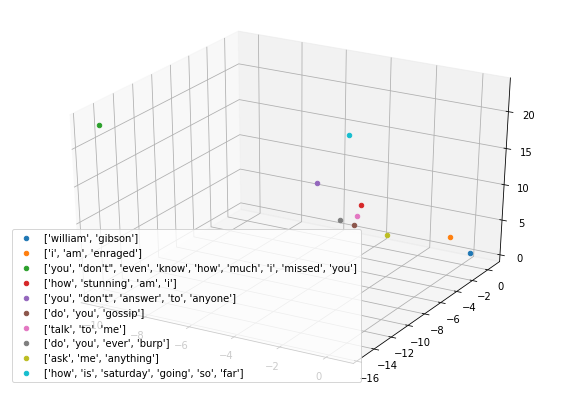

In [11]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
V=[]
for i in range (N):
    s=np.zeros(vector_size)
    for j in range(len(Q2W[i])):
        motInconnu(Q2W[i][j])
        wv=np.array(model.wv.get_vector(Q2W[i][j]))
        s+=wv
    V.append(list(s))
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
for i in range(10):
    ax.scatter3D(V[i][0],V[i][1],V[i][2],label=Q2W[i])
    #ax.scatter3D(V[i][0],V[i][1],V[i][2])
plt.legend()
#print(distance.cosine(V[1],V[3]))

In [12]:
def motInconnuKmeans(mot):
    try:
        model.wv.get_vector(mot.lower())   
    except:
        spell = SpellChecker()
        d=enchant.Dict("en_US")
        mot=str(mot)
        if d.check(spell.correction(mot)): 
            if mot==spell.correction(mot):
                return "I can't understand",False
            else:
                print("We can't understand this word ",mot,". Do you want to say this word ",'\'',spell.correction(mot),'\'')
                print("Please enter the correct word ! ")
                x = str(input())
                return x,False
        else:
            return "I don't know this word",False
    return mot,True


In [13]:
class Kmoyennes:

    def __init__(self,K, IterationMax=20):
        self.K=K
        self.N=0
        self.D=0
        self.IterationMax = IterationMax
        self.affectations = np.zeros((self.N))
        self.representants = np.zeros((self.K,self.D))

    def fit(self,X):
        self.N = X.shape[0]
        self.D = X.shape[1]
        representants_initiaux = np.random.random((self.K,self.D))
        representants = representants_initiaux       
        for iterations in range(self.IterationMax):
            affectations = self.maj_affectations(X, representants)
            representants = self.maj_representants(X, affectations)
        self.representants = representants
        self.affectations = affectations
        return self.representants
        
    #def dist(self,x1,x2):
    #       return np.sum((x1-x2)**2)**0.5
        
    def maj_affectations(self, X, r):
        a = np.zeros((self.N))
        for n in range(self.N):
            distances = np.zeros(self.K)
            for k in range(self.K):
                distances[k] = distance.cosine(X[n], r[k])
            a[n] = np.argmin(distances, axis=0)
        return a

    def barycentre(self,X):
        Nselection = X.shape[0]
        if Nselection != 0:
            resultat = X.sum(axis=0)/Nselection
        else:
            resultat = X.sum(axis=0)*0.0
        return resultat
    
    def maj_representants(self, X, a):       
        r = np.zeros((self.K,self.D))
        for k in range(self.K):
            masque = (a==k) ## cette condition booléenne permet d'obtenir un masque 
            r[k] = self.barycentre(X[masque])
        return r

In [14]:
def classifier(X,K,model = Kmoyennes, iterMax=10 ):
    Km = model(K=K, IterationMax=iterMax)
    Km.fit(X=X)
    affectations = Km.affectations
    representants = Km.representants
    return affectations, representants

In [15]:
X=np.array(V)
K = 10
affectations,representants = classifier(X, K = K)
flag=True
#print(affectations,representants)
def valide_affectations():
    for i in range (K):
        g0 = affectations==i
        if X[g0].shape[0]==0:
            return False
        else:
            continue
    return True    
           
    

while (flag):
    if valide_affectations():
        break
        
    else: 
        affectations,representants = classifier(X, K = K)
        print("upadate the affectations and representants ")
        
    

/Users/xuewen/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:698: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


upadate the affectations and representants 


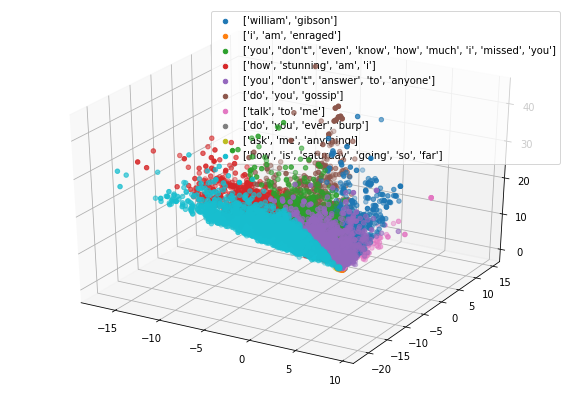

In [16]:
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
G=[]
for k in range(K):
    g0 = affectations==k
    G.append(X[g0])
    #print(X[g0])
    ax.scatter3D(X[g0,0],X[g0,1],X[g0,2],label=Q2W[k])
plt.legend()


In [17]:
def nearestVector(vector,groupe):
    minimum=distance.cosine(groupe[0],vector)
    index=0
    for i in range(len(groupe)):
        #print(distance.cosine(groupe[i],vector))
        if (distance.cosine(groupe[i],vector)<minimum):
            minumum=distance.cosine(vector,groupe[i])
            index=i
    return index              

In [29]:
def NeighborVector(seuil,vector,groupe,nbN):
    neighbor={}
    index=[]
    nb=0
    for i in range(len(groupe)):
        d=distance.cosine(groupe[i],vector)
        if (d<seuil):
            neighbor[d]=i
    for i in sorted(neighbor):
        if(nb==nbN):
            return index
        nb+=1
        index.append(neighbor[i])
    return index
        

In [19]:
def getQVsomme(tab):
    s=np.zeros(vector_size)
    for each in tab:      
        wv=np.array(model.wv.get_vector(each))
        s+=wv
    return list(s)

In [20]:
#ratio_train = 0.8
ratio_test = 0.2
#et pour valid dataset ??

Nv = len(V)
Nt = int(Nv*ratio_test)
Ntrain =  Nv- Nt
print("test size = ", Nt, "\ndata size = ", Nv)


X_test = np.array(V[-Nt:].copy())
X_train = np.array(V[0:Ntrain].copy())

X_test.shape, X_train.shape

test size =  2349 
data size =  11746


((2349, 3), (9397, 3))

In [21]:
import random

In [77]:
#seuil=0.06
def chatbot(question,memoire,seuil = 0.06 ):
    Dally=["Dallying me is not a gentleman's behavior !!! ","Let's change a topic!","Stop play with my affection !!"]
    Q= question.lower()
    q = sep_ponct(Q)
    tab = ' '.join(q).split()
    if(len(tab)==0):
        return "Are you kidding me?",memoire  
                             
    for i in range(len(tab)):
        tab[i],b=motInconnuKmeans(tab[i])
        if tab[i]=="I can't understand":
            return "I am sorry,I can't understand what did you ask",memoire
        while(b==False):
            tab[i],b=motInconnuKmeans(tab[i])
    
    QV=getQVsomme(tab) 
    nearestRepresentanrs=nearestVector(QV,representants) 
    g0 = affectations==nearestRepresentanrs
    
    if(memoire.count(QV)==5):
        return "Benben is tired! See you next time!! Bye!!!!!",memoire
    if(memoire.count(QV)>=3):
        memoire.append(QV)
        return random.choice(Dally),memoire
    
    if(memoire.count(QV)!=0):
        neighbor=NeighborVector(0.03,QV,X[g0],3)
        #print(neighbor)
        memoire.append(QV)
        return dataA[random.choice(neighbor)],memoire
    memoire.append(QV)
    
    
    for i in range(len(X_train)):
        if QV==list(X_train[i]):
            nearestIndex=V.index(QV)
            #print("here in train, QV = ", QV)
            return dataA[nearestIndex],memoire
        

    nearestIndexCloture=nearestVector(QV,X[g0])  
    nearestIndex=V.index(list(X[g0][nearestIndexCloture]))
    #print(nearestIndex,dataQ[nearestIndex])
    
   # print(distance.cosine(list(X[g0][nearestIndexCloture]),QV))
    if(distance.cosine(list(X[g0][nearestIndexCloture]),QV)>seuil):
        return "I am so sorry, I can't give an answer "
    return dataA[nearestIndex] ,memoire

In [78]:
def chatbotSansClassification(question,memoire, seuil = 0.06):
    Dally=["Dallying me is not a gentleman's behavior !!! ","Let's change a topic!","Stop play with my affection !!"]
    Q= question.lower()
    q = sep_ponct(Q)
    tab = ' '.join(q).split()
    if(len(tab)==0):
        return "Are you kidding me?"  ,memoire                   
    for i in range(len(tab)):
        tab[i],b=motInconnu(tab[i])
        if tab[i]=="I don't know this word":
            return "I don't know this word",memoire
        while(b==False):
            tab[i],b=motInconnu(tab[i])
    QV=getQVsomme(tab)
    if(memoire.count(QV)==5):
        return "Benben is tired! See you next time!! Bye!!!!!",memoire
    if(memoire.count(QV)>=3):
        memoire.append(QV)
        return random.choice(Dally),memoire
    if(memoire.count(QV)!=0):
        neighbor=NeighborVector(0.03,QV,V,3)
        #print(neighbor)
        memoire.append(QV)
        if(len(neighbor)!=0):
            return dataA[random.choice(neighbor)],memoire
    memoire.append(QV)
    
    for i in range(len(X_train)):
        if QV==list(X_train[i]):
            nearestIndex=V.index(QV)
            #print("here in train, QV = ", QV)
            return dataA[nearestIndex],memoire
    nearestIndex=nearestVector(QV,V)
    if(distance.cosine(V[nearestIndex],QV)>seuil):
        return "I am so sorry, I can't give an answer ",memoire
    return dataA[nearestIndex] ,memoire

In [87]:
def letsChat(ModelChatbot):
    goodBye = ['bye', 'goodbye','good bye', 'have a nice day','see you']
    memoire=[]
    print("benben: "+"Ask me something! ")
    chat = True
    while(chat):
        Q = str(input()) #entrer une phrase
        if(Q.lower() in goodBye):
            print(random.choice(goodBye))
            return
        answer,memoire = ModelChatbot(Q,memoire)
        if(answer=="Are you kidding me?" or answer=="Benben is tired! See you next time!! Bye!!!!!"):
            print("benben: ",answer)  
            return
        print("benben: ",answer)   

In [88]:
letsChat(chatbotSansClassification)

benben: Ask me something! 
hi
benben:  Oh, hi
bye
good bye


In [64]:
letsChat(chatbot)

Ask me something! 
how old are you
benben:  Age doesn't really apply to me. 
how old are you
[3062, 2093, 727]
benben:  I'm here if you need me.
how old are you
[3062, 2093, 727]
benben:  I'm here if you need me.
how old are you
[3062, 2093, 727]
benben:  I'm just a piece of software .
how old are you
[3062, 2093, 727]
benben:  I hope you're able to get some rest soon.
how old are you
[3062, 2093, 727]
benben:  I'm here if you need me.
bye
bye


#0.07307243670603059: distance what's your name vs answer 
#0.06816835295193202: distance red vs orange